# An Overview of time and coordinates:

### Converting times, representing coordinates, matching catalogs

### For more information

+ See the [coordinates notebook](../Extras/04-Coordinates/astropy_coordinates.ipynb) in the original tutorial.
+ Documentation of the [astropy time package](https://docs.astropy.org/en/stable/time/index.html)
+ Documentation os the [astropy coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html)

Astronomers use a wide variety of coordinate systems and formats to represent sky coordinates of celestial objects. For example, you may be familiar with terms like "right ascension" and "declination" or "galactic latitude/longitude," and you may have seen angular coordinate components represented as "0h39m15.9s," "00:39:15.9," or 9.81625º. `astropy.coordinates` provides tools for representing the coordinates of objects and transforming them between different systems. 

In this tutorial, we will explore how the `astropy.coordinates` package and related Astropy functionality can be used to help in planning observations or other exercises focused on large coordinate catalogs. 

You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link.

Some of the exercises below are quite complex to complete. For this reason, we provide a possible solution to each one (although there are many possible right answers!). Also note that there is likely not enough time to complete *all* of the exercises in the time we have. So if you're stuck on or disinterested in an exercise, we encourage you to skip over it and come back only if you have time later.

## Preliminary imports

We start by importing some general packages we will need below:

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance, EarthLocation
from astropy.io import fits
from astropy.table import QTable, Table
from astropy.utils.data import download_file

Note: If the next cell fails, make sure you have installed `astroquery` by running:
```
pip install astroquery
```
in your terminal. If so, you will need to go to "Kernel->Restart" in this notebook after installing.

## Times

Keeping time can be a messy business, but astropy can make it easier! There are many different units that you may need to use, and many different conventions for representing those times, all implemented in astropy.

First, we import the Time object and represent a time with a Julian date:

In [ ]:
from astropy.time import Time

t = Time(2455000, format='jd')

## Alternatively, you could initialize the same time with: 
# t = Time('2009-06-17 12:00')

t

You can see that by default the time scale is in UTC, the format provided was JD and it is represented in that format to the right.

### Time scales and formats

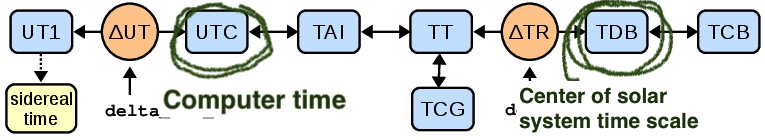


The (long) list of time formats is here: [https://docs.astropy.org/en/stable/time/index.html#time-format](https://docs.astropy.org/en/stable/time/index.html#time-format)

You can convert between time formats by calling the name of the time format that you want as an attribute on the time object, like this:  

In [ ]:
t.jd, t.iso, t.datetime

Let's say you want to convert to a different scale, like from UTC to UT1, just add a `ut1` to the attribute:

In [ ]:
t.ut1.iso

You can quickly initialize a vector time array of 10 linearly separated times, starting at the current time, like so: 

In [ ]:
times = Time.now() + np.linspace(0, 1, 10) * u.day
times

### Time scales frequently used in AAVSO-related work: UTC and TDB

UTC is computer time. It runs at the rate of an atomic clock on the surface of the Earth, with leap seconds added (or subtracted) on a regular basis to keep it roughly in sync with UT1.

TDB is time at the barycenter (center of mass) of the solar system, ands runs at the rate of an atomic clock after correcting for the effect of motion and gravity.

**There is a roughly 1 minute offset between these two scales.**

## Representing on-sky locations with `astropy.coordinates`

In Astropy, the most common way of representing and working with sky coordinates is to use the `SkyCoord` object. A `SkyCoord` can be created directly from angles or arrays of angles with associated units, as demonstrated below. 

To get started, let's assume that we want to create a `SkyCoord` object for the center of the open cluster NGC 188 so that later we can query and retrieve stars that might be members of the cluster. Let's also assume, for now, that we already know the sky coordinates of the cluster to be (12.11, 85.26) degrees in the ICRS coordinate frame. The ICRS — sometimes referred to as "equitorial" or "J2000" coordinates — is currently the most common astronomical coordinate frame for stellar or extragalactic astronomy, and is the default coordinate frame for `SkyCoord`. We could therefore create a `SkyCoord` object for the center of NGC 188 as:

In [ ]:
dy_her_center = SkyCoord(247.82805 * u.deg, 11.99796 * u.deg)
dy_her_center

It is generally recommended to explicitly specify the frame your coordinates are in. In this case, because ICRS is the default, this would be an equivalent way of creating our `SkyCoord` object:

In [ ]:
dy_her_center = SkyCoord(247.82805 * u.deg, 11.99796 * u.deg, frame='icrs')
dy_her_center

As we will see below, there are many other supported coordinate frames.

In the above initializations, we passed in `astropy.units.Quantity` objects with angular units to specify the angular components of our sky coordinates. However, `SkyCoord` will also accept string-formatted coordinates either as separate strings for Right Ascension (RA) and Declination (Dec) or a single string:

In [ ]:
SkyCoord('00h48m26.4s', '85d15m36s', frame='icrs')

Some string representations do not explicitly define units, so you would have to specify the units explicitly if they are not included in the string:

In [ ]:
SkyCoord('00:48:26.4 85:15:36', unit=(u.hour, u.deg), 
         frame='icrs')

For more information and examples on initializing `SkyCoord` objects, [see this documentation](http://docs.astropy.org/en/latest/coordinates/skycoord.html).

For the initializations above, we assumed that we already had the coordinate component values ready. If you do not know the coordinate values, and the object you are interested in is in [SESAME](http://cdsweb.u-strasbg.fr/cgi-bin/Sesame), you can also automatically look up and load coordinate values from its name using the `SkyCoord.from_name()` class method<sup>1</sup> ([docs](http://docs.astropy.org/en/latest/coordinates/index.html#convenience-methods)). Note, however, that this requires an internet connection. It is safe to skip this cell if you are not connected to the internet because we already defined it above.

<sub> <sup>1</sup>If you don't know what a class method is, think of it like an alternative constructor for a `SkyCoord` object — calling `SkyCoord.from_name()` with a name gives you a new `SkyCoord` object. For more detailed background on what class methods are and when they're useful, see [this page](https://julien.danjou.info/blog/2013/guide-python-static-class-abstract-methods).</sub>

In [ ]:
# NOTE: skip this cell if you do not have an internet connection

dy_her_center = SkyCoord.from_name('dy her')
dy_her_center

The `SkyCoord` object we created has various ways of accessing the information contained within it. All `SkyCoord` objects have attributes that allow you to retrieve the coordinate component data, but the component names will change depending on the coordinate frame of the `SkyCoord` you have. In our case, we have a `SkyCoord` with ICRS coordinates: The component names are therefore lower-case abbreviations of Right Ascension, `.ra`, and Declination, `.dec`:

In [ ]:
dy_her_center.ra, dy_her_center.dec

These ``ra`` and ``dec`` attributes return specialized [``Quantity``](http://docs.astropy.org/en/stable/units/index.html) objects (actually, a subclass called [``Angle``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Angle.html), which in turn is subclassed by [``Latitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Latitude.html) and [``Longitude``](http://docs.astropy.org/en/stable/api/astropy.coordinates.Longitude.html)).  These objects store angles and provide pretty representations of those angles, as well as some useful attributes to quickly convert to common angle units. For example, in a Jupyter notebook, these objects know how to represent themselves using LaTeX:

In [ ]:
dy_her_center.ra

In [ ]:
dy_her_center.dec

We can also retrieve the component values in different units:

In [ ]:
dy_her_center.ra.hour, dy_her_center.ra.radian, dy_her_center.ra.degree

And format the values into strings with specified units ([docs](http://docs.astropy.org/en/latest/coordinates/formatting.html)), for example:

In [ ]:
dy_her_center.ra.to_string(unit=u.hourangle, sep=':')

### Correcting for light travel times

One important modification you need to make when working with AAVSO data, for example, is to correct the time of observation what it would be at the position of the Sun instead of the earth. Failing to do so adds a signal to your data with period of one year and a time shift of up to ±7 minutes.

There are two ways of doing this, one common in variable star work and one common in the exoplanet world.

To calculate either of these we need to provide the location of the observation

In [ ]:
location = EarthLocation(lat=46.86678, lon=263.54672)

#### Heliocentric Julian Date (HJD, time scale is UTC)

This is the time at which the event would have happened had the observer been at the center of the Sun, almost always on the UTC time scale.

astropy prrovides a function for doing this sort of conversion, called `light_travel_time`

In [ ]:
helio_correction = t.light_travel_time(dy_her_center, kind='heliocentric', location=location)
helio_correction

In [ ]:
hjd = t + helio_correction
hjd, hjd - t

#### Barycentric Julian Date (BJD, time scale is TDB)

This is the time at which the event would have ahppened had the observer been at the barycenter of the solar system, almost always on the TDB time scale.

astropy prrovides a function for doing this sort of conversion, called `light_travel_time`

In [ ]:
bary_correction = t.light_travel_time(dy_her_center, kind='barycentric', location=location)
bary_correction

In [ ]:
bjd = t + bary_correction  # this will be in UTC because t was UTC...
bjd = bjd.tdb              # ...so convert it to TDB
bjd, bjd - t

## Coordinates, time and tables

Let's read in the AAVSO data on DY Her and calculate the heliocentric correction to the observation times.

In [ ]:
aavso_dy_her = Table.read('aavsodata_654253b413f61.txt', format='ascii')

We'll take a look at the table to remind ourselves what it contains.

In [ ]:
aavso_dy_her[:10]

To do the heliocentric correction we need the time of the observation in UTC, which is in the table, and the coordinates, whch are not.

Fortunately, we have the coordinates already, and can make time objects from the column.

In [ ]:
times = Time(aavso_dy_her['JD'], format='jd', scale='utc')

Astropy is just as happy to calculate light travel time for several times as it is for a single time.

In [ ]:
hjd_correction = times.light_travel_time(dy_her_center, kind='heliocentric', location=location)
hjd = times + hjd_correction

In [ ]:
hjd[:10]

### A little more about tables, and table formats 

Things like the heliocentric julian date we've calculated can be made into astropy table columns. 

In [ ]:
aavso_dy_her['HJD'] = hjd
aavso_dy_her[:5]

They are still time objects, so we can do things like convert to a different time scale

In [ ]:
aavso_dy_her['HJD'][:5].tdb

#### Some formats for saving keep more information than others

If we save this table as a CSV then read it back in, astropy no longer knows that the HJD column is Time.

In [ ]:
aavso_dy_her.write('aavso_as_csv.csv', overwrite=True)

new_aavso_csv = Table.read('aavso_as_csv.csv')
new_aavso_csv['HJD'].tdb   # This will fail now

If you save the table as ECSV or FITS then astropy will still know that the HJD column is a time.

In [ ]:
aavso_dy_her.write('aavso_as_ecsv.ecsv', overwrite=True)

new_aavso_ecsv = Table.read('aavso_as_ecsv.ecsv')
new_aavso_ecsv['HJD'].tdb  # This will work

---

## Transforming between coordinate systems and planning observations

Imagine that we found something exciting in our exploration of the data for NGC 188, and we would like to follow-up with our own observations of a given sources. `astropy.coordinates` provides tools to assist in planning observations, especially from ground-based observatories, as we will see below. 

### Introducting frame transformations

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/stable/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key concept to understand is that all coordinates in Astropy are in particular reference "frames," and we can transform between a specific `SkyCoord` object in one frame to another. For example, we can transform our previously-defined center of NGC 188 from ICRS to another coordinate frame, like Galactic coordinates. In `astropy.coordinates`, this is typically done using the `.transform_to()` method:

In [ ]:
dy_her_center.transform_to('galactic')

This method either takes a string name of a coordinate frame, or an instance of a coordinate frame object itself. For example, the class representing the Galactic frame is:

In [ ]:
from astropy.coordinates import Galactic
dy_her_center.transform_to(Galactic())

For coordinate frames that do not require additional parameters, the transformations can also be accessed by attributes of the `SkyCoord` object. Another way to transform to the Galactic frame, then, is to do:

In [ ]:
dy_her_center.galactic

Note that changing frames also changes some of the attributes of the object, most often the names of the component attributes. Recall that for the ICRS frame the components were `ra` and `dec`. For the Galactic frame, the corresponding longitude and latitude are named `l` and `b`:

In [ ]:
dy_her_gal = dy_her_center.galactic
dy_her_gal.l, dy_her_gal.b

Note that the names `.ra` and `.dec` will therefore *not* work on this transformed `SkyCoord`:

In [ ]:
# THIS SHOULD ERROR:
dy_her_gal.ra

### Using frame transformations to get to AltAz

To determine whether a target is observable from a given observatory on Earth, we need to convert our coordinate to a frame local to an on-earth observer. The most common choice for such a frame is horizontal coordinates, or "AltAz" coordinates. The `AltAz` coordinate frame requires a few extra pieces of information to define: a location on Earth, and the time of observation. These are handled with the `EarthLocation` and `Time` objects, respectively:

In [ ]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

Let's assume we will be observing at Kitt Peak in a few weeks. We can retrieve the Earth location of Kitt Peak using the `EarthLocation.of_site` method:

In [ ]:
observing_location = EarthLocation.of_site('Kitt Peak')
# List of all locations can be viewed using
# EarthLocation.get_site_names()

And let's pretend our observing run starts on Jan 20 this year:

In [ ]:
observing_time = Time('2020-01-20 1:00')  # 1am UTC=6pm AZ mountain time

Now we use these to create an `AltAz` frame object. Note that this frame has even more information about the atmosphere, which can be used to correct for atmospheric refraction. Here we leave that alone, because the default is to ignore this effect (by setting the air pressure to 0).

In [ ]:
from astropy.coordinates import AltAz

altaz = AltAz(location=observing_location, obstime=observing_time)
altaz

Now we can transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Kitt Peak at the requested time:

In [ ]:
ngc188_center.transform_to(altaz)

Alright, the cluster NGC 188 is up at 6PM local time at Kitt Peak, but that is pretty early to be observing. We could try various times one at a time to see if the airmass is at a darker time, but we can do better — we can make an airmass plot for the whole night:

In [ ]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 6, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_altaz = AltAz(location=observing_location, obstime=full_night_times)
full_night_altaz_coords = ngc188_center.transform_to(full_night_altaz)

plt.plot(delta_hours, full_night_altaz_coords.secz)
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(0.9, 3)
plt.tight_layout()

It looks like our source is observable at relatively high airmass for most of the night, but the minimum airmass is at the start of the night. When can we start observing with proper dark skies? Astropy also provides a ``get_sun`` function that can be used to check the sky position of the sun to check, for example, when we are in 18-degree twilight:

In [ ]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_altaz)
plt.plot(delta_hours, full_night_sun_coos.alt.deg)
plt.axhline(-18, color='k')
plt.xlabel('Hours from 6PM AZ time')
plt.ylabel('Sun altitude')
plt.tight_layout()

It looks like it's just below -18 degrees a little after 7PM local time, so we can start observing our target then!

---

## More than just sky positions: Including velocity information in `SkyCoord`

As we have seen above, the `SkyCoord` object can store scalars or arrays of positional coordinate information, can transform between different coordinate frames, and can cross-match sets of coordinates. But wait, there's more! `astropy.coordinates` also supports representing and transforming *velocity* information along with positions ([docs](http://docs.astropy.org/en/latest/coordinates/velocities.html)).

### Passing velocity data in to `SkyCoord`

Velocity data is passed in to `SkyCoord` in a very similar way to the positional coordinates demonstrated above. However, velocity data must be passed in using keyword arguments, meaning that you must write out the velocity component names, for example:

In [ ]:
SkyCoord(ra=10*u.deg, 
         dec=20*u.deg,
         pm_ra_cosdec=1*u.mas/u.yr,
         pm_dec=2*u.mas/u.yr)

In the above, we create a `SkyCoord` instance with sky position and proper motion data. The proper motion component names for ICRS coordinates are, by default, `pm_ra_cosdec` and `pm_dec` ("pm" for "proper motion"). You can also specify radial velocity data via the `radial_velocity` argument, for example:

In [ ]:
velocity_coord = SkyCoord(ra=10*u.deg, 
                          dec=20*u.deg,
                          pm_ra_cosdec=1*u.mas/u.yr,
                          pm_dec=2*u.mas/u.yr,
                          radial_velocity=100*u.km/u.s)
velocity_coord

A `SkyCoord` object with velocity data can be transformed to other frames just like the objects we are used to from above:

In [ ]:
velocity_coord.transform_to('galactic')

An important caveat, however, is that some reference frames require knowing distance in order to transform all velocity components — something we did not specify in the `velocity_coord` definition above:

In [ ]:
# THIS SHOULD ERROR:
velocity_coord.transform_to(altaz)

### Evolving coordinate positions between epochs

For nearby or fast-moving stars, a star's position could change appreciably between two well-spaced observations of the source. For such cases, it might be necessary to evolve the position of the star using the proper motion or velocity of the star in order to accurately predict its position at a new time. Below, we will demonstrate this using data from the Digitized Sky Survey (DSS; digital scans of photographic plates observed in the 1950s) and data from the *Gaia* mission (at epoch J2015.5).

The star HD 219829 has a very large proper motion, close to 0.5 arcsec/year. Between the DSS and *Gaia*, we therefore expect that the position of the star has changed by about 0.5 arcmin; let's see if this is the case! To start, we will query the *Gaia* catalog to retrieve data for this star (but skip the cell below if you do not have an internet connection):

In [ ]:
# NOTE: skip this cell if you do not have an internet connection

hd219829_coord_2015 = SkyCoord(349.72896715675495, 5.405115847648341, unit=u.deg)
hd219829_gaia_table = Gaia.query_object_async(hd219829_coord_2015, radius=2*u.arcsec)
hd219829_gaia_table = QTable(hd219829_gaia_table)  # ignore any warnings output by this!

hd219829_coord = SkyCoord(ra=hd219829_gaia_table['ra'],
                          dec=hd219829_gaia_table['dec'],
                          distance=Distance(parallax=hd219829_gaia_table['parallax']),
                          pm_ra_cosdec=hd219829_gaia_table['pmra'],
                          pm_dec=hd219829_gaia_table['pmdec'],
                          radial_velocity=hd219829_gaia_table['radial_velocity'],
                          obstime=Time('J2015.5'))

In [ ]:
hd219829_coord = SkyCoord(ra=349.72896716*u.deg, 
                          dec=5.40511585*u.deg,
                          distance=34.47896*u.pc,
                          pm_ra_cosdec=483.41659*u.mas/u.yr,
                          pm_dec=-114.86339*u.mas/u.yr,
                          obstime=Time('J2015.5'))

Note above that we specify a new keyword argument, `obstime`, to `SkyCoord`: This is the observation time of the coordinates, and will be important later when we evolve the position of this star using its proper motion.

We now have the position and proper motion for HD 219829. Let's now query the DSS to retrieve a FITS image of the field around this star, using the STSCI DSS image cutout service. Again, skip the cell below if you do not have an internet connection:

In [ ]:
# NOTE: skip this cell if you do not have an internet connection

dss_cutout_filename = download_file(f"http://archive.stsci.edu/cgi-bin/dss_search?"
                                    f"f=FITS&ra={hd219829_coord.ra.degree}&dec={hd219829_coord.dec.degree}"
                                    f"&width=4&height=4")  # width/height in arcmin

In [ ]:
dss_cutout_filename = 'dss_hd219829.fits'

We can now load the FITS image of the cutout and use `astropy.visualization` to display the image using its World Coordinate System (WCS) info ([docs](http://docs.astropy.org/en/latest/visualization/wcsaxes/index.html)). By passing in the WCS information (included in the FITS cutout header), we can over-plot a marker for the *Gaia*-measured sky position of HD 219829:

In [ ]:
from astropy.wcs import WCS

hdu = fits.open(dss_cutout_filename)[0]
wcs = WCS(hdu.header)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

The bright star (as observed by DSS) is our target, and the red circle is where *Gaia* observed this star — it has moved! But, we can account for this, and predict the position of the star at around the time the DSS plate was observed (let's assume it was exactly 1950 — this is not strictly correct, but should be good enough).

To account for the proper motion of the source and evolve the position to a new time, we can use the `SkyCoord.apply_space_motion()` method ([docs](http://docs.astropy.org/en/latest/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.apply_space_motion)):

In [ ]:
hd219829_coord_1950 = hd219829_coord.apply_space_motion(new_obstime=Time('J1950'))  # ignore the ErfaWarning

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

# Plot the predicted (past) position:
ax.scatter(hd219829_coord_1950.ra.degree,
           hd219829_coord_1950.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:blue')

The predicted position of the star from 1950 is much closer to where the star is in the DSS image. Success!

## Wrap-up

This tutorial covers a lot of material, but `astropy.coordinates` has even more functionality that we were unable to cover in this workshop. For documentation on other features of `astropy.coordinates`, check out [the astropy.coordinates section of the Astropy documentation](http://astropy.readthedocs.org/en/stable/coordinates/index.html).

You might also be interested in [the astroplan affiliated package](http://astroplan.readthedocs.org/), which uses the `astropy.coordinates` to do more advanced versions of the observation planning tasks briefly covered above.